https://lerner98.medium.com/implementing-sift-in-python-36c619df7945

In [1]:
import numpy as np
from scipy.ndimage.filters import convolve 

# DOG approximation
difference de 2 gaussienne

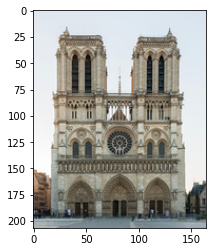

In [18]:
import matplotlib.pyplot as plt

# Code de test
root = "/home/tttienthinh/Documents/Programmation/VaccineArm/image/NDParis/"
name = "NDParis1-r.jpg"
input_file = f'{root}{name}'

# Ouverture de l'image
im = imread(input_file)
plt.imshow(im)

Text(0.5, 1.0, 'Filtre de Gauss pour sigma 1.3')

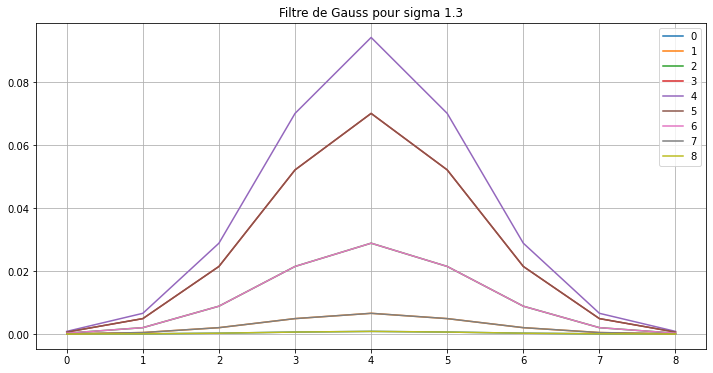

In [33]:
def gaussian_filter(sigma):
    size = 2*np.ceil(3*sigma)+1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
    return g/g.sum()
s0=1.3
gaussian_liste = gaussian_filter(s0)
plt.figure(figsize=(12, 6))
for i in range(len(gaussian_liste)):
    plt.plot(gaussian_liste[i], label=i)
plt.grid()
plt.legend()
plt.title(f"Filtre de Gauss pour sigma {s0}")

In [3]:
def generate_octave(init_level, s, sigma):
    octave = [init_level]

    k = 2**(1/s)
    kernel = gaussian_filter(k * sigma)

    for i in range(s+2):
        next_level = convolve(octave[-1], kernel)
        octave.append(next_level)

    return octave

In [4]:
def generate_gaussian_pyramid(im, num_octave, s, sigma):
    pyr = []

    for _ in range(num_octave):
        octave = generate_octave(im, s, sigma)
        pyr.append(octave)
        im = octave[-3][::2, ::2]

    return pyr

In [5]:
def generate_DoG_octave(gaussian_octave):
    octave = []

    for i in range(1, len(gaussian_octave)):
        octave.append(gaussian_octave[i] - gaussian_octave[i-1])

    return np.concatenate([o[:,:,np.newaxis] for o in octave], axis=2)

def generate_DoG_pyramid(gaussian_pyramid):
    pyr = []

    for gaussian_octave in gaussian_pyramid:
        pyr.append(generate_DoG_octave(gaussian_octave))

    return pyr

# Detection d'extremum

In [6]:
def get_candidate_keypoints(D, w=16):
    candidates = []

    ''' Start '''
    # These 2 lines aren't specified in the paper but it makes it so the extrema
    # are found within the entire octave. They are always found in the first or
    # last layer so I probably have something wrong with my DoG pyramid construction.
    D[:,:,0] = 0
    D[:,:,-1] = 0
    ''' End '''
    # have to start at w//2 so that when getting the local w x w descriptor, we don't fall off
    for i in range(w//2+1, D.shape[0]-w//2-1):
        for j in range(w//2+1, D.shape[1]-w//2-1):
            for k in range(1, D.shape[2]-1): 
                patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    candidates.append([i, j, k])

    return candidates

# Localisation de point

In [7]:
def localize_keypoint(D, x, y, s):
    dx = (D[y,x+1,s]-D[y,x-1,s])/2.
    dy = (D[y+1,x,s]-D[y-1,x,s])/2.
    ds = (D[y,x,s+1]-D[y,x,s-1])/2.

    dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
    dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
    dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
    dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
    dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
    dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]

    J = np.array([dx, dy, ds])
    HD = np.array([
        [dxx, dxy, dxs],
        [dxy, dyy, dys],
        [dxs, dys, dss]])
    
    offset = -LA.inv(HD).dot(J)    # I know you're supposed to do something when an offset dimension is >0.5 but I couldn't get anything to work.
    return offset, J, HD[:2,:2], x, y, s

# Elimination des points

In [8]:
def find_keypoints_for_DoG_octave(D, R_th, t_c, w):
    candidates = get_candidate_keypoints(D, w)
    #print('%d candidate keypoints found' % len(candidates))

    keypoints = []

    for i, cand in enumerate(candidates):
        y, x, s = cand[0], cand[1], cand[2]
        offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

        contrast = D[y,x,s] + .5*J.dot(offset)
        if abs(contrast) < t_c: continue

        w, v = LA.eig(H)
        r = w[1]/w[0]
        R = (r+1)**2 / r
        if R > R_th: continue

        kp = np.array([x, y, s]) + offset
        if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: continue # throw out boundary points because I don't want to deal with them

        keypoints.append(kp)

    #print('%d keypoints found' % len(keypoints))
    return np.array(keypoints)

In [9]:
def get_keypoints(DoG_pyr, R_th, t_c, w):
    kps = []

    for D in DoG_pyr:
        kps.append(find_keypoints_for_DoG_octave(D, R_th, t_c, w))

    return kps

In [10]:
def cart_to_polar_grad(dx, dy):
    m = np.sqrt(dx**2 + dy**2)
    theta = (np.arctan2(dy, dx)+np.pi) * 180/np.pi
    return m, theta

def get_grad(L, x, y):
    dy = L[min(L.shape[0]-1, y+1),x] - L[max(0, y-1),x]
    dx = L[y,min(L.shape[1]-1, x+1)] - L[y,max(0, x-1)]
    return cart_to_polar_grad(dx, dy)

def quantize_orientation(theta, num_bins):
    bin_width = 360//num_bins
    return int(np.floor(theta)//bin_width)

def fit_parabola(hist, binno, bin_width):
    centerval = binno*bin_width + bin_width/2.

    if binno == len(hist)-1: rightval = 360 + bin_width/2.
    else: rightval = (binno+1)*bin_width + bin_width/2.

    if binno == 0: leftval = -bin_width/2.
    else: leftval = (binno-1)*bin_width + bin_width/2.
    
    A = np.array([
        [centerval**2, centerval, 1],
        [rightval**2, rightval, 1],
        [leftval**2, leftval, 1]])
    b = np.array([
        hist[binno],
        hist[(binno+1)%len(hist)], 
        hist[(binno-1)%len(hist)]])

    x = LA.lstsq(A, b, rcond=None)[0]
    if x[0] == 0: x[0] = 1e-6
    return -x[1]/(2*x[0])

In [11]:
def assign_orientation(kps, octave, num_bins=36):
    new_kps = []
    bin_width = 360//num_bins

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)

        sigma = kp[2]*1.5
        w = int(2*np.ceil(sigma)+1)
        kernel = gaussian_filter(sigma)

        L = octave[...,s]
        hist = np.zeros(num_bins, dtype=np.float32)

        for oy in range(-w, w+1):
            for ox in range(-w, w+1):
                x, y = cx+ox, cy+oy
                
                if x < 0 or x > octave.shape[1]-1: continue
                elif y < 0 or y > octave.shape[0]-1: continue
                
                m, theta = get_grad(L, x, y)
                weight = kernel[oy+w, ox+w] * m

                bin = quantize_orientation(theta, num_bins)
                hist[bin] += weight

        max_bin = np.argmax(hist)
        new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, max_bin, bin_width)])

        max_val = np.max(hist)
        for binno, val in enumerate(hist):
            if binno == max_bin: continue

            if .8 * max_val <= val:
                new_kps.append([kp[0], kp[1], kp[2], fit_parabola(hist, binno, bin_width)])

    return np.array(new_kps)

# Defintion de l'orientation

In [12]:
def get_patch_grads(p):
    r1 = np.zeros_like(p)
    r1[-1] = p[-1]
    r1[:-1] = p[1:]

    r2 = np.zeros_like(p)
    r2[0] = p[0]
    r2[1:] = p[:-1]

    dy = r1-r2

    r1[:,-1] = p[:,-1]
    r1[:,:-1] = p[:,1:]

    r2[:,0] = p[:,0]
    r2[:,1:] = p[:,:-1]

    dx = r1-r2

    return dx, dy

def get_histogram_for_subregion(m, theta, num_bin, reference_angle, bin_width, subregion_w):
    hist = np.zeros(num_bin, dtype=np.float32)
    c = subregion_w/2 - .5

    for i, (mag, angle) in enumerate(zip(m, theta)):
        angle = (angle-reference_angle) % 360
        binno = quantize_orientation(angle, num_bin)
        vote = mag

        # binno*bin_width is the start angle of the histogram bin
        # binno*bin_width+bin_width/2 is the center of the histogram bin
        # angle - " is the distance from the angle to the center of the bin 
        hist_interp_weight = 1 - abs(angle - (binno*bin_width + bin_width/2))/(bin_width/2)
        vote *= max(hist_interp_weight, 1e-6)

        gy, gx = np.unravel_index(i, (subregion_w, subregion_w))
        x_interp_weight = max(1 - abs(gx - c)/c, 1e-6)
        y_interp_weight = max(1 - abs(gy - c)/c, 1e-6)
        vote *= x_interp_weight * y_interp_weight

        hist[binno] += vote

    return hist

def get_local_descriptors(kps, octave, w=16, num_subregion=4, num_bin=8):
    descs = []
    bin_width = 360//num_bin

    for kp in kps:
        cx, cy, s = int(kp[0]), int(kp[1]), int(kp[2])
        s = np.clip(s, 0, octave.shape[2]-1)
        kernel = gaussian_filter(w/6) # gaussian_filter multiplies sigma by 3
        L = octave[...,s]

        t, l = max(0, cy-w//2), max(0, cx-w//2)
        b, r = min(L.shape[0], cy+w//2+1), min(L.shape[1], cx+w//2+1)
        patch = L[t:b, l:r]

        dx, dy = get_patch_grads(patch)

        if dx.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dx.shape[0]:]
            else: kernel = kernel[:dx.shape[0]]
        if dx.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dx.shape[1]:]
            else: kernel = kernel[:dx.shape[1]]

        if dy.shape[0] < w+1:
            if t == 0: kernel = kernel[kernel.shape[0]-dy.shape[0]:]
            else: kernel = kernel[:dy.shape[0]]
        if dy.shape[1] < w+1:
            if l == 0: kernel = kernel[kernel.shape[1]-dy.shape[1]:]
            else: kernel = kernel[:dy.shape[1]]

        m, theta = cart_to_polar_grad(dx, dy)
        dx, dy = dx*kernel, dy*kernel

        subregion_w = w//num_subregion
        featvec = np.zeros(num_bin * num_subregion**2, dtype=np.float32)

        for i in range(0, subregion_w):
            for j in range(0, subregion_w):
                t, l = i*subregion_w, j*subregion_w
                b, r = min(L.shape[0], (i+1)*subregion_w), min(L.shape[1], (j+1)*subregion_w)

                hist = get_histogram_for_subregion(m[t:b, l:r].ravel(), 
                                                theta[t:b, l:r].ravel(), 
                                                num_bin, 
                                                kp[3], 
                                                bin_width,
                                                subregion_w)
                featvec[i*subregion_w*num_bin + j*num_bin:i*subregion_w*num_bin + (j+1)*num_bin] = hist.flatten()

        featvec /= max(1e-6, LA.norm(featvec))
        featvec[featvec>0.2] = 0.2
        featvec /= max(1e-6, LA.norm(featvec))
        descs.append(featvec)

    return np.array(descs)

# Execution du programme

In [36]:
# Importation
from skimage.color import rgb2gray
from scipy.ndimage.filters import convolve

from skimage.io import imread

import argparse
import pickle
import os
from os.path import isdir

import matplotlib.pyplot as plt

In [14]:
class SIFT(object):
    def __init__(self, im, s=3, num_octave=4, s0=1.3, sigma=1.6, r_th=10, t_c=0.03, w=16):
        self.im = convolve(rgb2gray(im), gaussian_filter(s0))
        self.s = s
        self.sigma = sigma
        self.num_octave = num_octave
        self.t_c = t_c
        self.R_th = (r_th+1)**2 / r_th
        self.w = w

    def get_features(self):
        gaussian_pyr = generate_gaussian_pyramid(self.im, self.num_octave, self.s, self.sigma)
        DoG_pyr = generate_DoG_pyramid(gaussian_pyr)
        kp_pyr = get_keypoints(DoG_pyr, self.R_th, self.t_c, self.w)
        feats = []

        for i, DoG_octave in enumerate(DoG_pyr):
            kp_pyr[i] = assign_orientation(kp_pyr[i], DoG_octave)
            feats.append(get_local_descriptors(kp_pyr[i], DoG_octave))

        self.kp_pyr = kp_pyr
        self.feats = feats

        return feats


## Ouverture de l'image

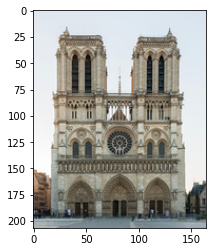

In [15]:
root = "/home/tttienthinh/Documents/Programmation/VaccineArm/image/NDParis/"
name = "NDParis1-r.jpg"
input_file = f'{root}{name}'

# Ouverture de l'image
im = imread(input_file)
plt.imshow(im)

(207, 164)


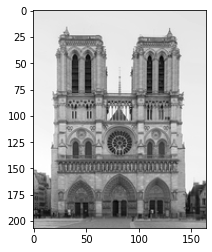

In [49]:
rgb2gray_im = rgb2gray(im)
print(rgb2gray_im.shape)
plt.imshow(rgb2gray_im, cmap='gray')

(207, 164)


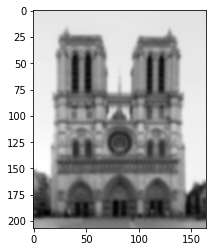

In [48]:
convolve_im = convolve(rgb2gray(im), gaussian_filter(s0))
print(convolve_im.shape)
plt.imshow(convolve_im, cmap='gray')

In [ ]:
sift_detector = SIFT(im)
_ = sift_detector.get_features()
kp_pyr = sift_detector.kp_pyr